# Unet for road detection#

This notebook trains a Unet model for road detection on the [Massachusetts road dataset](https://www.cs.toronto.edu/~vmnih/data/).

The data is downloaded by the notebook.

The model is trained on this datset using either the Binary Cross Entropy loss or the DICE Loss.

We also provide a funtion to evaluate the IoU of the model on the rest of the dataset.

We also implement a post-processing step using a graph-cut similar to [this article](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=4&ved=2ahUKEwjQiI_T-Y_oAhWKy4UKHbSEBUgQFjADegQICBAB&url=http%3A%2F%2Fwww.escience.cn%2Fsystem%2Fdownload%2F73857&usg=AOvVaw1heXNFrXY920gtaKVr7_3P). This requires the PyMaxFlow module which can be installed using ```pip install PyMaxFlow```.

## Library imports ##

In [0]:
# Graph-cut lib
pip install PyMaxflow


     |████████████████████████████████| 133kB 4.8MB/s 
  Created wheel for PyMaxflow: filename=PyMaxflow-1.2.12-cp36-cp36m-linux_x86_64.whl size=537267 sha256=8787d257bd658602ea58f515e17ad492a0aa91f79e12af23a4f4776a8942dede
  Stored in directory: /root/.cache/pip/wheels/56/ab/a8/12b43e2024215b384364145b140e14a838b45ad39989f51a4f
Successfully built PyMaxflow


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from PIL import Image

import random
import torchvision.transforms.functional as TF

import glob

from tqdm import tqdm_notebook as tqdm
import numpy as np
import matplotlib.pyplot as plt

from torchvision import transforms

In [0]:
import maxflow
from skimage import feature, color

## Downloading the dataset ##

### Creating the required folders ###

In [0]:
%%bash
mkdir -p data/train
cd data/train
mkdir input
mkdir target

In [0]:
%%bash
mkdir -p data/test
cd data/test
mkdir input
mkdir target

In [0]:
%%bash
mkdir -p data/val
cd data/val
mkdir input
mkdir target

### Download training data ###

In [0]:
%%bash
cd data/train/input
wget https://www.cs.toronto.edu/~vmnih/data/mass_roads/train/sat/index.html
echo 'grep'
grep -o "http://www.cs.toronto.edu/~vmnih/data/mass_roads/train/sat/\w*\w*_15.tiff" index.html > urls.txt 
sort -u urls.txt | wget -nc -i-
rm index.html
rm urls.txt


grep


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [0]:
%%bash
cd data/train/target
wget https://www.cs.toronto.edu/~vmnih/data/mass_roads/train/map/index.html
echo 'grep'
grep -o "http://www.cs.toronto.edu/~vmnih/data/mass_roads/train/map/\w*\w*_15.tif" index.html > urls.txt 
sort -u urls.txt | wget -nc -i-
rm index.html
rm urls.txt


grep


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



### Download validation data ###

In [0]:
%%bash
cd data/val/input
wget https://www.cs.toronto.edu/~vmnih/data/mass_roads/valid/sat/index.html
echo 'grep'
grep -o "http://www.cs.toronto.edu/~vmnih/data/mass_roads/valid/sat/\w*\w*_15.tiff" index.html > urls.txt 
sort -u urls.txt | wget -nc -i-
rm index.html
rm urls.txt


grep


--2020-03-26 16:48:16--  https://www.cs.toronto.edu/~vmnih/data/mass_roads/valid/sat/index.html
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1582 (1.5K) [text/html]
Saving to: ‘index.html’

     0K .                                                     100%  271M=0s

2020-03-26 16:48:17 (271 MB/s) - ‘index.html’ saved [1582/1582]

--2020-03-26 16:48:17--  http://www.cs.toronto.edu/~vmnih/data/mass_roads/valid/sat/10228690_15.tiff
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6765892 (6.5M) [image/tiff]
Saving to: ‘10228690_15.tiff’

     0K .......... .......... .......... .......... ..........  0%  434K 15s
    50K .......... .......... .......... .......... .......... 

In [0]:
%%bash
cd data/val/target
wget https://www.cs.toronto.edu/~vmnih/data/mass_roads/valid/map/index.html
echo 'grep'
grep -o "http://www.cs.toronto.edu/~vmnih/data/mass_roads/valid/map/\w*\w*_15.tif" index.html > urls.txt 
sort -u urls.txt | wget -nc -i-
rm index.html
rm urls.txt


grep


--2020-03-26 16:48:20--  https://www.cs.toronto.edu/~vmnih/data/mass_roads/valid/map/index.html
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1554 (1.5K) [text/html]
Saving to: ‘index.html’

     0K .                                                     100%  104M=0s

2020-03-26 16:48:20 (104 MB/s) - ‘index.html’ saved [1554/1554]

--2020-03-26 16:48:20--  http://www.cs.toronto.edu/~vmnih/data/mass_roads/valid/map/10228690_15.tif
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2250110 (2.1M) [image/tiff]
Saving to: ‘10228690_15.tif’

     0K .......... .......... .......... .......... ..........  2%  436K 5s
    50K .......... .......... .......... .......... ..........  4%

### Download test data ###

In [0]:
%%bash
cd data/test/input
wget https://www.cs.toronto.edu/~vmnih/data/mass_roads/test/sat/index.html
echo 'grep'
grep -o "http://www.cs.toronto.edu/~vmnih/data/mass_roads/test/sat/\w*\w*_15.tiff" index.html > urls.txt 
sort -u urls.txt | wget -nc -i-
rm index.html
rm urls.txt


grep


--2020-03-27 12:53:34--  https://www.cs.toronto.edu/~vmnih/data/mass_roads/test/sat/index.html
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5488 (5.4K) [text/html]
Saving to: ‘index.html’

     0K .....                                                 100%  238M=0s

2020-03-27 12:53:34 (238 MB/s) - ‘index.html’ saved [5488/5488]

--2020-03-27 12:53:34--  http://www.cs.toronto.edu/~vmnih/data/mass_roads/test/sat/10378780_15.tiff
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6765892 (6.5M) [image/tiff]
Saving to: ‘10378780_15.tiff’

     0K .......... .......... .......... .......... ..........  0%  459K 14s
    50K .......... .......... .......... .......... ..........  1

In [0]:
%%bash
cd data/test/target
wget https://www.cs.toronto.edu/~vmnih/data/mass_roads/test/map/index.html
echo 'grep'
grep -o "http://www.cs.toronto.edu/~vmnih/data/mass_roads/test/map/\w*\w*_15.tif" index.html > urls.txt 
sort -u urls.txt | wget -nc -i-
rm index.html
rm urls.txt


grep


--2020-03-27 12:53:44--  https://www.cs.toronto.edu/~vmnih/data/mass_roads/test/map/index.html
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5390 (5.3K) [text/html]
Saving to: ‘index.html’

     0K .....                                                 100%  175M=0s

2020-03-27 12:53:44 (175 MB/s) - ‘index.html’ saved [5390/5390]

--2020-03-27 12:53:44--  http://www.cs.toronto.edu/~vmnih/data/mass_roads/test/map/10378780_15.tif
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2250110 (2.1M) [image/tiff]
Saving to: ‘10378780_15.tif’

     0K .......... .......... .......... .......... ..........  2%  420K 5s
    50K .......... .......... .......... .......... ..........  4%  

## Training the model ##

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Defining a custom dataset ###
This dataset apply data augmentation to both the input and the predictions.

In [0]:
VAL = "val"
TRAIN = "train"
TEST = "test"

class RoadDataset(Dataset):
    def __init__(self,folder,mode=TRAIN, transform=True, crop_size=None):
        super().__init__()
        self.mode = mode
        
        assert self.mode in [VAL, TRAIN, TEST]
        self.folder = folder + "/" + mode + "/"
            
        self.target_list = glob.glob(self.folder + "target/*.tif")
        self.input_list = [self.folder + "input/" + fname[-15:] + "f" for fname in self.target_list]

        
        assert len(self.input_list) == len(self.target_list)
        
        self.apply_transform = transform
        self.crop_size = crop_size

        
    def __len__(self):
        return len(self.input_list)
    
    def transform(self, x, y):
        # Random horizontal flipping
        if random.random() > 0.5:
            x = TF.hflip(x)
            y = TF.hflip(y)
        
        # Random vertical flipping
        if random.random() > 0.5:
            x = TF.vflip(x)
            y = TF.vflip(y)
            
        # Random Rotation (change to fill with 1)
        angle = random.randint(-45,45)
        x = TF.rotate(x, angle, fill=(1, 1, 1))
        y = TF.rotate(y, angle, fill=(0,))
        
        # Random crop (some times this results in an image with no relevant data when the crop is too close to the edge)
        i = random.randint(0,1500-224)
        j = random.randint(0,1500-224)
        x = TF.crop(x, i, j, 224, 224)
        y = TF.crop(y, i, j, 224, 224)
                
        return x,y
        
    def __getitem__(self, idx):
        img = Image.open(self.input_list[idx])
        target = Image.open(self.target_list[idx])
        
        if self.apply_transform:
            img, target = self.transform(img, target)
        #else:
        #    img = TF.center_crop(img, self.crop_size)
        #    target = TF.center_crop(img, self.crop_size)

        img = TF.to_tensor(img)
        target = TF.to_tensor(target)

        return img, target

    

In [0]:
batch_size = 8

In [0]:
trainset = RoadDataset("data")
testset = RoadDataset("data", "test", transform=False, crop_size=None)
valset = RoadDataset("data", "val", transform=False, crop_size=500)



train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(testset, batch_size=2, shuffle=False)
val_loader = DataLoader(valset, batch_size=1, shuffle=False)


### Defining the model ###

In [0]:
from unet import *

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.up1 = Up(1024, 256, bilinear)
        self.up2 = Up(512, 128, bilinear)
        self.up3 = Up(256, 64, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return torch.sigmoid(logits)

In [0]:
model = UNet(3, 1)
model = model.to(device)

### Training the model ###

In [0]:
lr = 0.001
n_epoch = 10
optim = torch.optim.Adam(model.parameters(), lr = lr)

In [0]:
criterion = nn.BCELoss()
l = 1.5

PATH = "modelIoU12.pth"

for epoch in range(n_epoch):
    running_loss = 0
    for inp, target in tqdm(train_loader):
        optim.zero_grad()
        
        pred = model(inp.to(device))
        target = target.to(device)
        
        # BCE loss
        loss = criterion(pred, target)
        
        # Dice loss
        # loss += - l * 2 * torch.sum(pred*target)/(torch.sum(pred) + torch.sum(target))
        loss.backward()
        optim.step()
        
        running_loss += loss.item()
    torch.save(model.state_dict(), PATH)
    print(epoch, running_loss)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



0 -0.20041573792696



1 -41.97899679839611



2 -51.43287677317858



3 -60.70913518965244



4 -68.3190265595913



5 -73.02284103631973



6 -76.21373587846756



7 -82.47049281001091



8 -83.84730948507786



9 -89.03393243253231



10 -92.62907445430756



11 -90.74862509220839



12 -93.43309944868088



13 -97.13070970773697



14 -95.44460381567478



15 -96.88469949364662



16 -99.78956776857376



17 -98.11148546636105



18 -104.53978760540485



19 -104.81199392676353


### Load a pretrained model ###
If necessary.

In [0]:
# This cell loads a pretrained model if necessary.
PATH = "model20bce.pth"
model.load_state_dict(torch.load(PATH))
model = model.eval()

### Evaluating the model performance ###

In [0]:
def IoU(model, dataloader):
    """
    Compute the IoU of model on dataloader.
    """
    score = 0
    tot = 0
    model.eval()
    for x, y in tqdm(dataloader):
        with torch.no_grad():
            x = x.to(device)
            y = y.to(device)
            preds = model(x.to(device)) > 0.25
            tot += len(x)
            I = (preds * y).sum(2).sum(2)
            U = torch.clamp(preds + y, 0, 1).sum(2).sum(2)
            score += torch.sum(I/U).item()
    return score/tot

In [0]:
IoU(model, test_loader)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


0.5661432962028348

### Visualising the results ##

In [0]:
# Gets the prediction of 4 batches

c = 0
targets = []
Xs = []
preds = []

for x, y in test_loader:
    if c >= 4: 
        break
    else:
        c +=1
        with torch.no_grad():
            preds.append(model(x.to(device)).cpu())
        targets.append(y)
        Xs.append(x)

In [0]:
y = preds[2].numpy()[0][0].copy()
x = Xs[2].numpy()[0].transpose(1,2,0).copy()
t = targets[2].numpy()[0][0].copy()

In [0]:
# Select part of the image to crop
xmin, xmax = 600, 1000
ymin, ymax = 0, 400

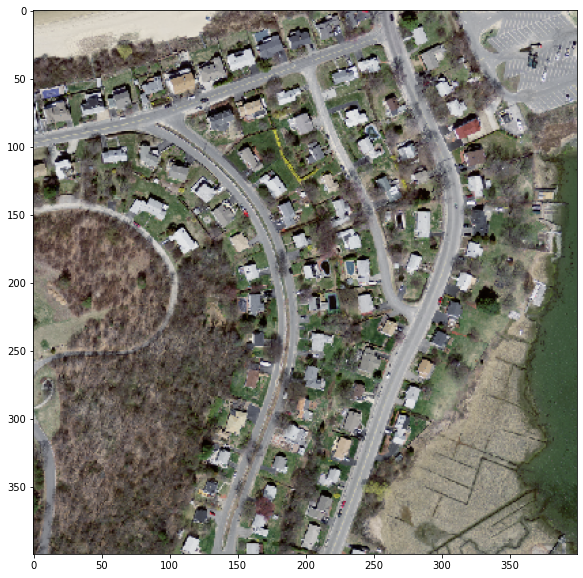

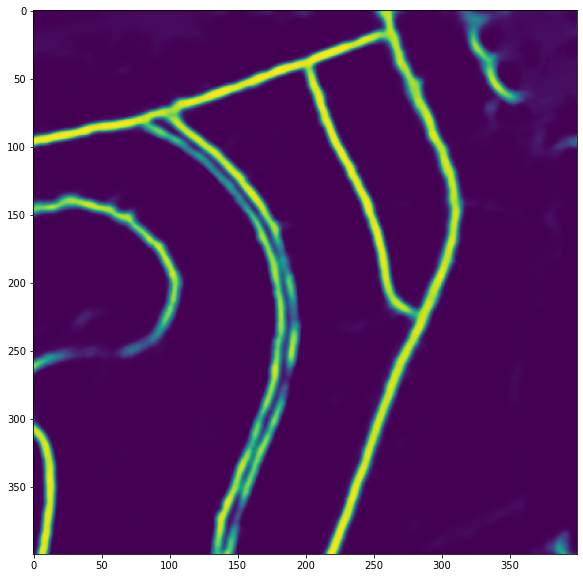

In [0]:
plt.figure(figsize=(10,10))
plt.imshow(x[ymin:ymax,xmin:xmax])
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(y[ymin:ymax,xmin:xmax])
plt.show()



In [0]:

def vis(img, pred, target, s=0.5):
    """
    Plot the satellite image img with the ground truth target in blue and the model prediction pred in red.
    s is the threshold above which a pixel is considered as a road.
    """
    img = img.copy()
    img[pred > s] += [0.5,0,0]
    img[target > 0.5] += [0,0,0.5]
    img = img.clip(0,1)
    plt.figure(figsize=(15,15))
    plt.imshow(img)
    return img


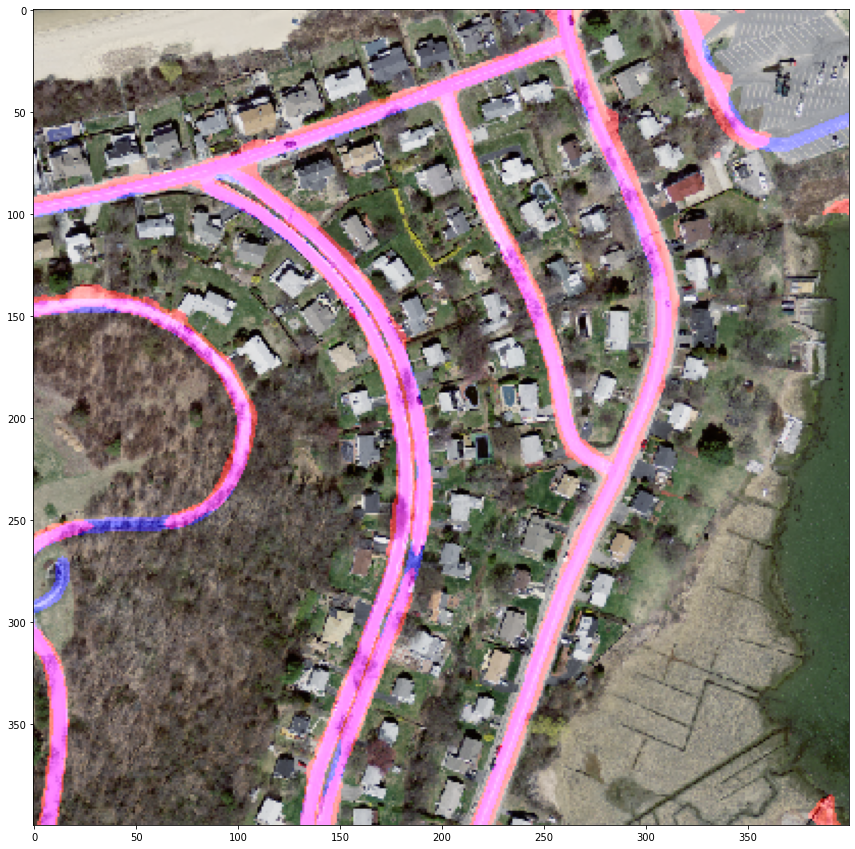

In [0]:
img = vis(x[ymin:ymax,xmin:xmax], y[ymin:ymax,xmin:xmax], t[ymin:ymax,xmin:xmax],s=0.15)
plt.show()

# vis(x,y,t)
# plt.show()

In [0]:
plt.imsave("unet.png", img)

### Postprocessing ###
This part uses a [graph cut](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=4&ved=2ahUKEwjQiI_T-Y_oAhWKy4UKHbSEBUgQFjADegQICBAB&url=http%3A%2F%2Fwww.escience.cn%2Fsystem%2Fdownload%2F73857&usg=AOvVaw1heXNFrXY920gtaKVr7_3P) to filter the results of the model.

In [0]:
def cannymap(x):
    """
    Compute the mean of the cannymap obtained on each channel of x with different threshold values.
    """
    res = np.zeros_like(x[:,:,0])
    thresholds = [0.15,0.1]
    for c in range(3):
        for t in thresholds:
            res += feature.canny(x[:,:,c], 1,t,1-t) 
    return res / (3 * len(thresholds))

In [0]:
edges = np.exp(-cannymap(x))

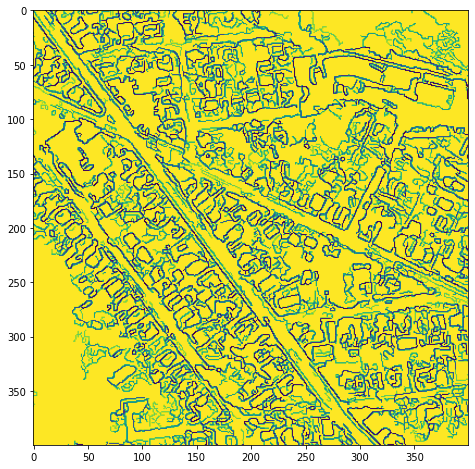

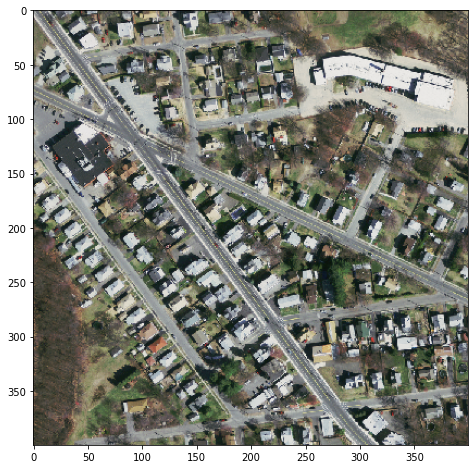

In [0]:
plt.figure(figsize=(8,8))
plt.imshow(edges[100:500,800:1200])
plt.show()
plt.imsave("edges.png",edges[100:500,800:1200])
plt.figure(figsize=(8,8))
plt.imshow(x[100:500,800:1200])
plt.show()

In [0]:
def mincut(x, y, edges, l=1):
    """
    Apply the graph cut on image x with predicted road probabilities y and edges.
    """
        
    g = maxflow.GraphFloat()
    nodeids = g.add_grid_nodes(y.shape)

    ir = range(y.shape[0])
    jr = range(y.shape[1])

    ii, jj = np.meshgrid(ir, jr, indexing='ij')

    epsilon = 1e-3

    #horizontal
    jjs = jj[:,1:]
    iis = ii[:,1:]
    ids = nodeids[:,1:]

    k = l * edges[:,1:]

    jjt = jj[:,:-1]
    iit = ii[:,:-1]
    idt = nodeids[:,:-1]

    diff = x[iis,jjs] - x[iit,jjt]
    diffnorm = np.linalg.norm(diff, axis=2)
    cost = (k/(diffnorm + epsilon)).reshape(-1)

    g.add_edges(ids, idt, cost, -cost)

    #vertical
    jjs = jj[1:,:]
    iis = ii[1:,:]
    ids = nodeids[1:,:]

    k = l * edges[1:,:]

    jjt = jj[:-1,:]
    iit = ii[:-1,:]
    idt = nodeids[:-1,:]

    diff = x[iis,jjs] - x[iit,jjt]
    diffnorm = np.linalg.norm(diff, axis=2)
    cost = (k/(diffnorm + epsilon)).reshape(-1)

    g.add_edges(ids, idt, cost, -cost)

    #diag \
    jjs = jj[1:,1:]
    iis = ii[1:,1:]
    ids = nodeids[1:,1:]

    k = l * edges[1:,1:]

    jjt = jj[:-1,:-1]
    iit = ii[:-1,:-1]
    idt = nodeids[:-1,:-1]

    diff = x[iis,jjs] - x[iit,jjt]
    diffnorm = np.linalg.norm(diff, axis=2)
    cost = (k/(diffnorm + epsilon)).reshape(-1)

    g.add_edges(ids, idt, cost, -cost)

    #diag /
    jjs = jj[:-1,1:]
    iis = ii[:-1,1:]
    ids = nodeids[:-1,1:]

    k = l * edges[:-1,1:]

    jjt = jj[1:,:-1]
    iit = ii[1:,:-1]
    idt = nodeids[1:,:-1]

    diff = x[iis,jjs] - x[iit,jjt]
    diffnorm = np.linalg.norm(diff, axis=2)
    cost = (k/(diffnorm + epsilon)).reshape(-1)

    g.add_edges(ids, idt, cost, -cost)



    g.add_grid_tedges(nodeids, -np.log(y), -np.log(1-y))

    g.maxflow()
    return g.get_grid_segments(nodeids)

In [0]:
def postprocess(x,y,l=1):
    #x = color.rgb2lab(x)
    edges = np.exp(-cannymap(x))
    return mincut(x, y, edges, l)


In [0]:
def IoU1(y,gt):
    """
    Computes the IoU for a simngle numpy image.
    """
    I = (y * gt).sum()
    U = (y + gt).clip(0, 1).sum()
    return np.sum(I/U)

In [0]:
ysup = y[ymin:ymax,xmin,xmax]>0.5


In [0]:
# The parameter l that is used in the graph cut part was chosen after trying multiple values.
sgm = postprocess(x[ymin:ymax,xmin,xmax], y[ymin:ymax,xmin,xmax], l=0.125)


In [0]:
print("before ", IoU1(ysup,t[ymin:ymax,xmin,xmax]))
print("after ", IoU1(sgm,t[ymin:ymax,xmin,xmax]))

before  0.7765582
after  0.7335029


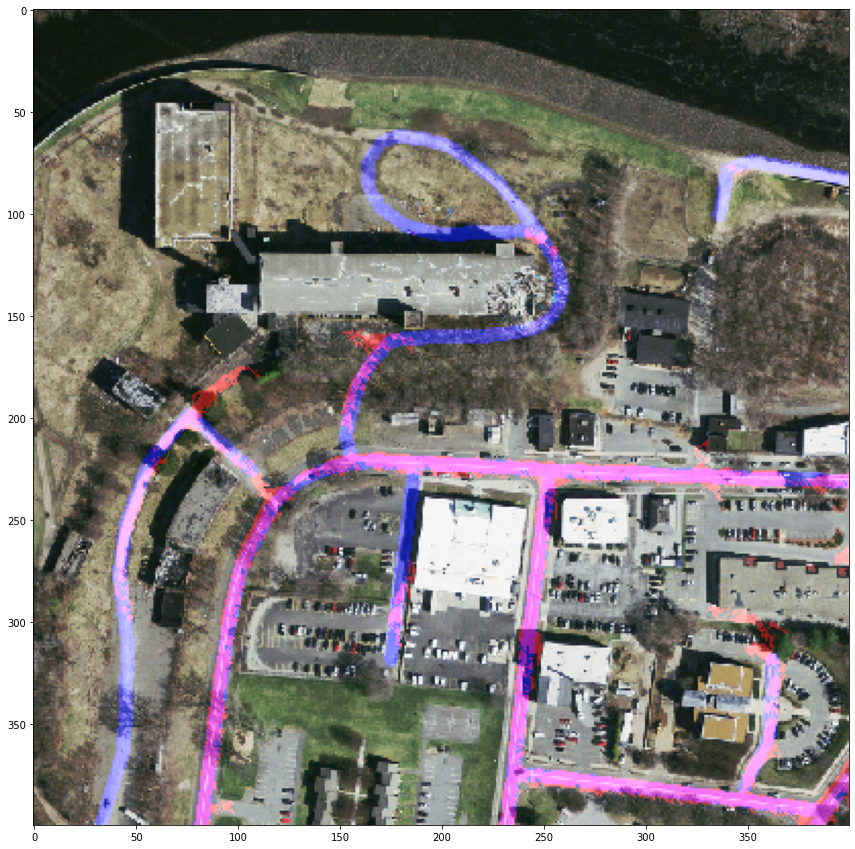

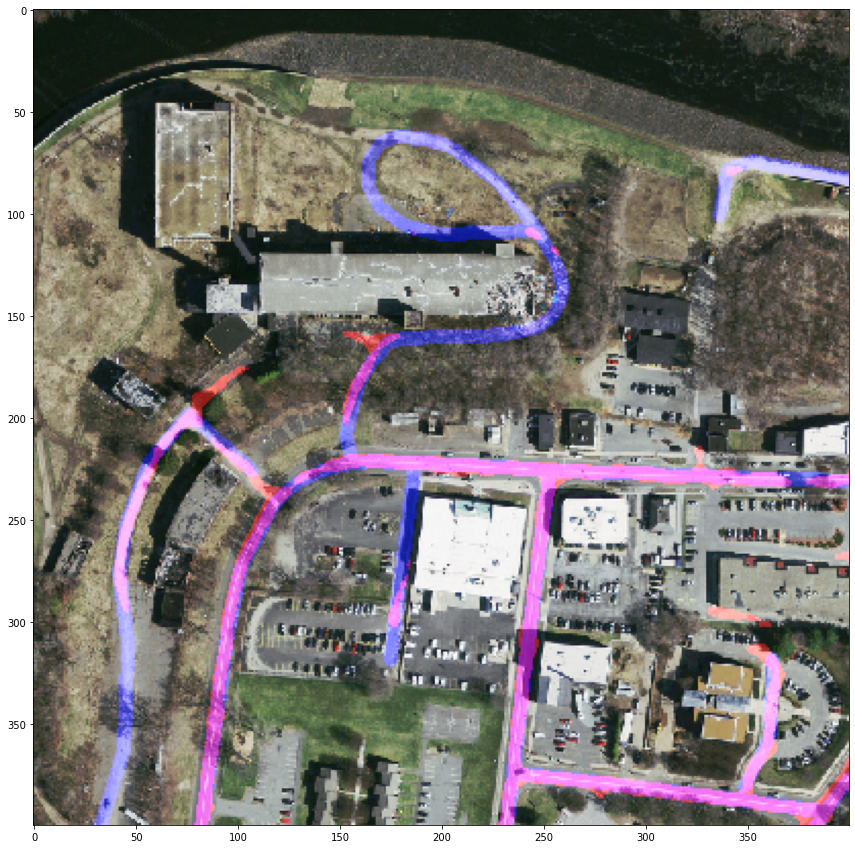

In [0]:
img = vis(x[ymin:ymax,xmin,xmax], sgm, t[ymin:ymax,xmin,xmax])
plt.show()
vis(x[ymin:ymax,xmin,xmax], y[ymin:ymax,xmin,xmax], t[ymin:ymax,xmin,xmax])
plt.show()


In [0]:
plt.imsave("gc.png",sgm)
plt.imsave("unetGC1.png",img)